<a href="https://colab.research.google.com/github/Hsuyeon01/ESAA/blob/main/Keras_CNN_Dog_or_Cat_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras CNN Dog or Cat Classification

## Import Library

In [14]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir('/content/drive/MyDrive/DATA/dog'))

['sampleSubmission.csv', 'train']


## Define Constants

In [37]:
FAST_RUN = True
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

## Prepare Training Data

In [16]:
filenames = os.listdir("/content/drive/MyDrive/DATA/dog/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [17]:
df.head()

,filename,category
0,cat.4369.jpg,0
1,cat.5088.jpg,0
2,dog.6216.jpg,1
3,dog.1021.jpg,1
4,dog.10208.jpg,1


In [18]:
df.tail()

,filename,category
135,dog.10036.jpg,1
136,cat.5936.jpg,0
137,dog.5247.jpg,1
138,dog.3434.jpg,1
139,dog.6982.jpg,1


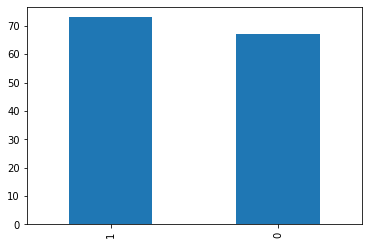

In [19]:
df['category'].value_counts().plot.bar()

## See sample image

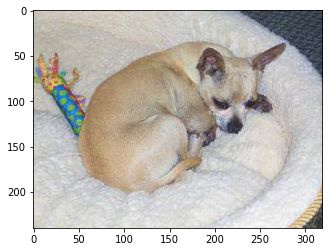

In [20]:
sample = random.choice(filenames)
image = load_img("/content/drive/MyDrive/DATA/dog/train/"+sample)
plt.imshow(image)

## Build Model

In [21]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

## Callbacks

In [22]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

### Early stop

In [23]:
earlystop = EarlyStopping(patience=10)

### Learning Rate Reduction

In [24]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [25]:
callbacks = [earlystop, learning_rate_reduction]

## Prepare data

In [26]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [27]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

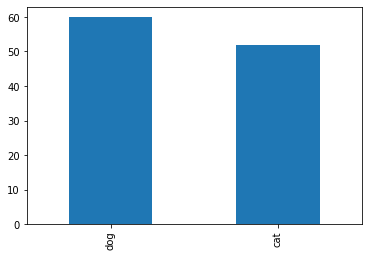

In [28]:
train_df['category'].value_counts().plot.bar()

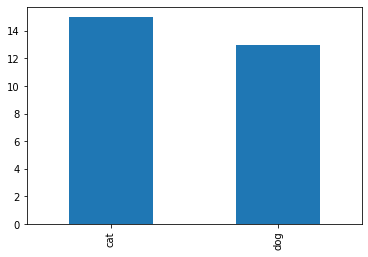

In [29]:
validate_df['category'].value_counts().plot.bar()

In [30]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

### Training Generator

In [31]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True, 
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/drive/MyDrive/DATA/dog/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 112 validated image filenames belonging to 2 classes.


### Validation Generator

In [33]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/drive/MyDrive/DATA/dog/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 28 validated image filenames belonging to 2 classes.


## See how our generator work

In [34]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator=train_datagen.flow_from_dataframe(
    example_df,
    "/content/drive/MyDrive/DATA/dog/train",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


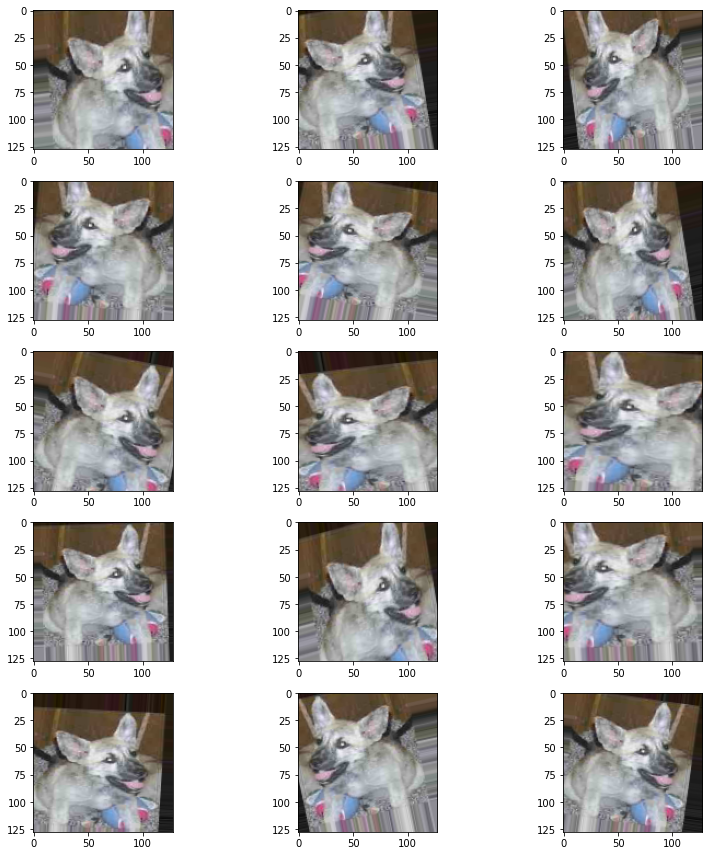

In [35]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Fit Model

In [38]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = total_validate//batch_size,
    steps_per_epoch = total_train//batch_size,
    callbacks=callbacks
)

<ipython-input-38-69e108e7e50a>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/3
7/7 [==============================] - ETA: 0s - loss: 0.8191 - accuracy: 0.7320

7/7 [==============================] - 7s 971ms/step - loss: 0.8191 - accuracy: 0.7320 - val_loss: 1.0012 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 2/3
7/7 [==============================] - ETA: 0s - loss: 0.8776 - accuracy: 0.7320

7/7 [==============================] - 10s 2s/step - loss: 0.8776 - accuracy: 0.7320 - val_loss: 1.6057 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 3/3
7/7 [==============================] - ETA: 0s - loss: 0.7829 - accuracy: 0.7216

7/7 [==============================] - 12s 2s/step - loss: 0.7829 - accuracy: 0.7216 - val_loss: 2.7909 - val_accuracy: 0.6000 - lr: 0.0010


## Save Model

In [39]:
model.save_weights('model.h5')

## Virtualize Training

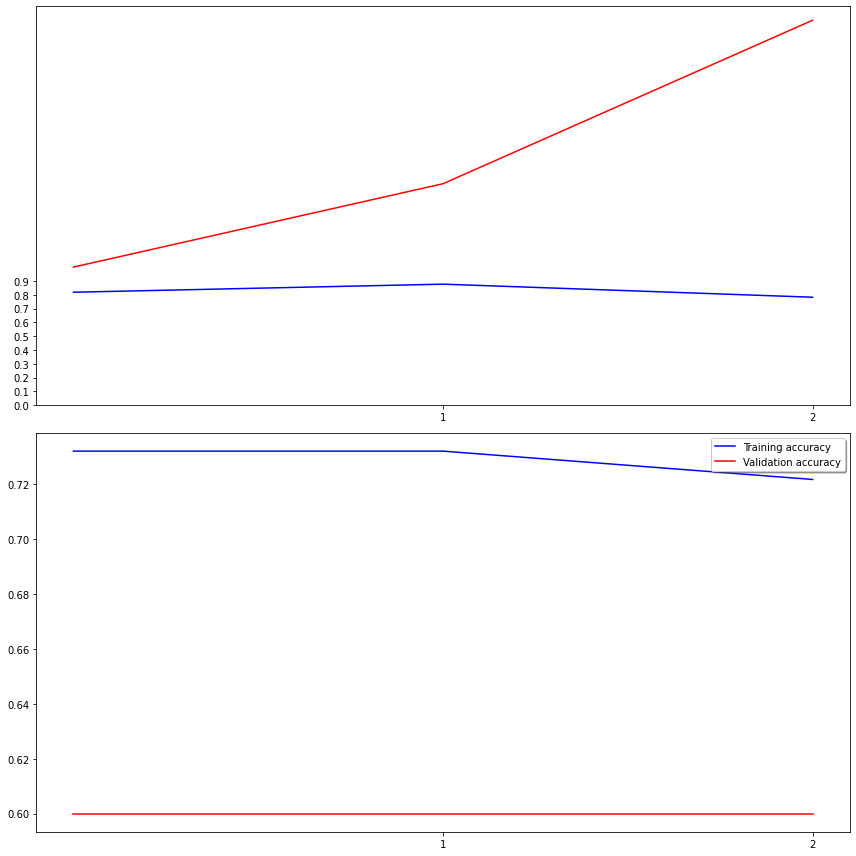

In [41]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Preparing Testing Data

In [53]:
test_filenames = os.listdir("/content/drive/MyDrive/DATA/dog/test_500")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

## Create Testing Generator

In [54]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/content/drive/MyDrive/DATA/dog/test_500", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 500 validated image filenames.


## Predict

In [55]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

<ipython-input-55-52619fd72ccc>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [56]:
test_df['category'] = np.argmax(predict, axis=-1)

In [57]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [58]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

### Virtualize Result

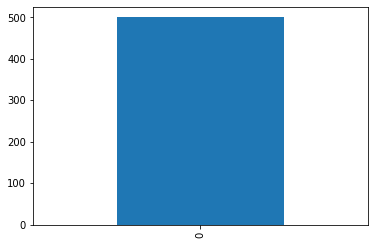

In [59]:
test_df['category'].value_counts().plot.bar()

### See predicted result with images

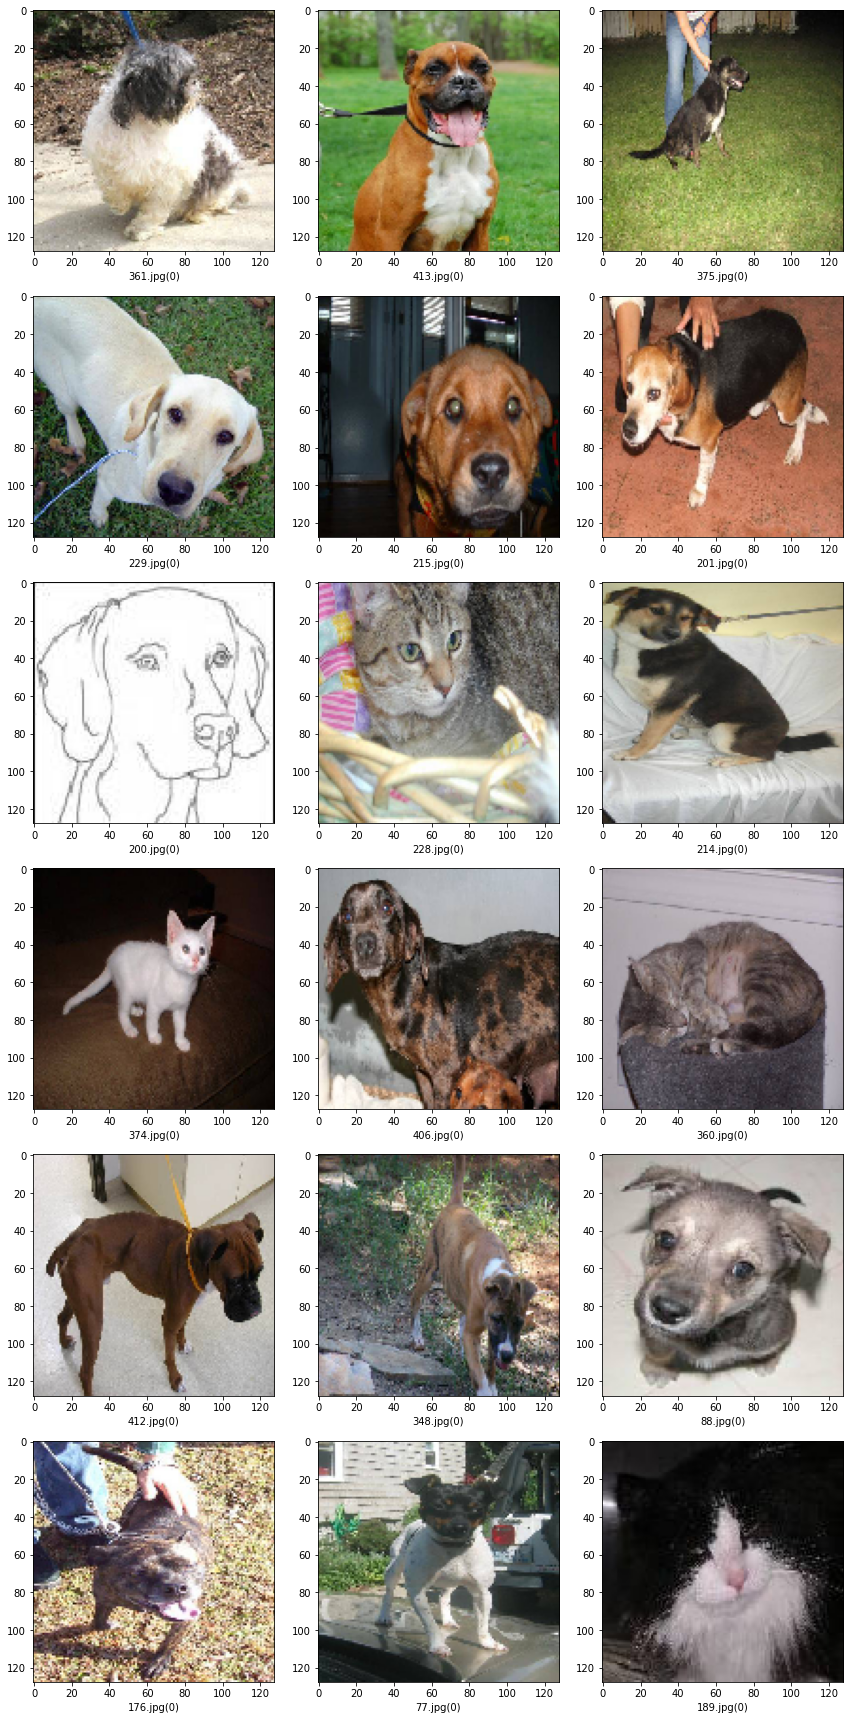

In [63]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/drive/MyDrive/DATA/dog/test_500/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()